In [ ]:
import numpy as np
import torch 
import torch.nn as nn
import torchvision
import timm
import matplotlib.pyplot as plt
import model.revit_model as mmvit
from munch import DefaultMunch
import yaml
import dataset.data as data
import torchvision.transforms.functional as F
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [2]:
def compute_distance_matrix(patch_size, num_patches, length):
  """Helper function to compute distance matrix."""

  distance_matrix = np.zeros((num_patches, num_patches))

  for i in range(num_patches):
    for j in range(num_patches):
      if i == j: # zero distance
        continue

      xi, yi = (int(i/length)), (i % length)
      xj, yj = (int(j/length)), (j % length)

      distance_matrix[i, j] = patch_size*np.linalg.norm([xi - xj, yi - yj])
  
  return distance_matrix

  

def compute_mean_attention_dist(patch_size, attention_weights, module=True):
  num_patches = attention_weights.shape[-1]
  length = int(np.sqrt(num_patches))
  assert (length**2 == num_patches), ("Num patches is not perfect square")

  distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
  h, w = distance_matrix.shape

  distance_matrix = distance_matrix.reshape((1, 1, h, w))/16
  if module:
    attention_weights = attention_weights.softmax(dim=-1)
  mean_distances = attention_weights*distance_matrix
  mean_distances = torch.sum(mean_distances, axis=-1) # sum along last axis to get average distance per token
  mean_distances = torch.mean(mean_distances, axis=-1) # now average across all the tokes

  return mean_distances

In [3]:
def build(cfg):
    """
    Helper function to build neural backbone

    Input:
        cfg: configuration dictionary
    
    Returns:
        net: Neural network moduel, nn.Module object

    """
    net = mmvit.MMViT(cfg=cfg)

    return net

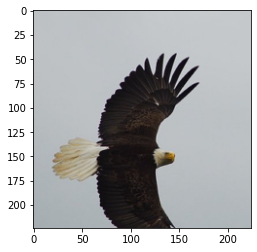

In [4]:
__IMGPATH__ = ""
__CFGPATH__ = "config/config-ReViT-B.yaml"

with open(__CFGPATH__, 'r') as stream:
    cfg = yaml.safe_load(stream=stream)
cfg = DefaultMunch.fromDict(cfg)  

net = build(cfg=cfg)  
ckpt = torch.load(cfg.SOLVER.load_path)
net.load_state_dict(ckpt['model'])
net.eval()

transforms = data.prepare_transform(cfg=cfg, mode='val')
img = cv.imread(__IMGPATH__)
pil_img = F.to_pil_image(img)
input_ = transforms(pil_img)
input_ = input_.view([1, input_.shape[0], input_.shape[1], input_.shape[2]])

with torch.no_grad():
    output_ = net(input_)

size = int((1.0 / cfg.DATA.VAL_CROP_RATIO) * 224)
resize = torchvision.transforms.Resize(size=size)
img = resize(F.to_pil_image(img))
centerCrop = torchvision.transforms.CenterCrop(size=224)
img = centerCrop(img)
img = np.array(img) 
img = img[:, :, ::-1].copy()
plt.imshow(img)


In [5]:
attn_maps = output_['attn_maps']

mean_distances = {}
for i in range(len(attn_maps)):
    mean_distances[f"block_{i}_distances"] = compute_mean_attention_dist(patch_size=16, attention_weights=attn_maps[i])


In [6]:
def attention_heatmaps(attention_scores, image, layer, cls_token=True):
        
    attentsions = attention_scores[layer]
    attentsions = attentsions.softmax(dim=-1)
    if cls_token:
        attentsions = attentsions[0, :, 0, 1:]
    else:    
        attentsions = attentsions.mean(dim=-2)

    w_featmap = image.shape[-1] // 16
    h_featmap = image.shape[-2] // 16
    # print(attentsions.shape)

    attn_map = attentsions.reshape(12, w_featmap, h_featmap)
    resize = torchvision.transforms.Resize((w_featmap * 16, h_featmap * 16))
    attn_map = resize(attn_map)
    return attn_map

def ExtractPriors(attention_scores, alpha=0.5):
    prior_attention = []
    for idx in range(len(attention_scores)):
        if idx == 0:
            prior_attention.append(attention_scores[idx])
        else:
            curr_attn = (0.5*attention_scores[idx]) - (0.5*attention_scores[idx-1])
            prior_attention.append(curr_attn)
    return prior_attention

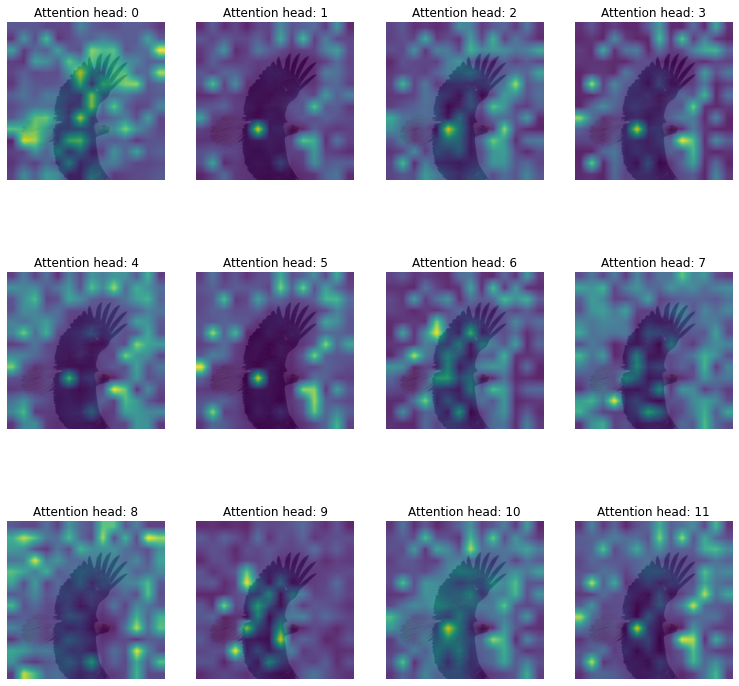

In [7]:
attn_maps = output_['attn_maps']
prior_maps = ExtractPriors(attn_maps)
maps = attention_heatmaps(prior_maps, input_, 11, False)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0
for i in range(3):
    for j in range(4):
        if img_count < 12:
            axes[i, j].imshow(img)
            axes[i, j].imshow(maps[img_count], cmap="viridis", alpha=0.8)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1
# fig.savefig("ReViT_attention_maps_fish_11.png")


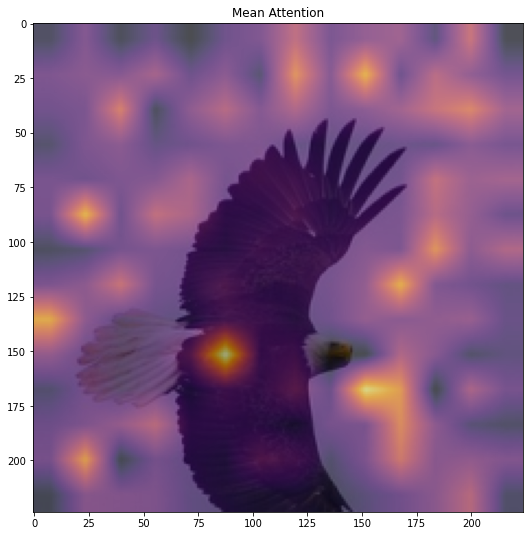

In [8]:
plt.figure(figsize=(9, 9))
mean_maps = maps.mean(dim=0)
img_count = 0
plt.imshow(img)
plt.imshow(mean_maps, cmap="inferno", alpha=0.6)
plt.title(f"Mean Attention")
plt.savefig("ReViT_attention_maps_eagle.png")
plt.show()            


In [9]:
mean_distances = {}
for i in range(len(attn_maps)):
    mean_distances[f"block_{i}_distances"] = compute_mean_attention_dist(patch_size=16, attention_weights=attn_maps[i])

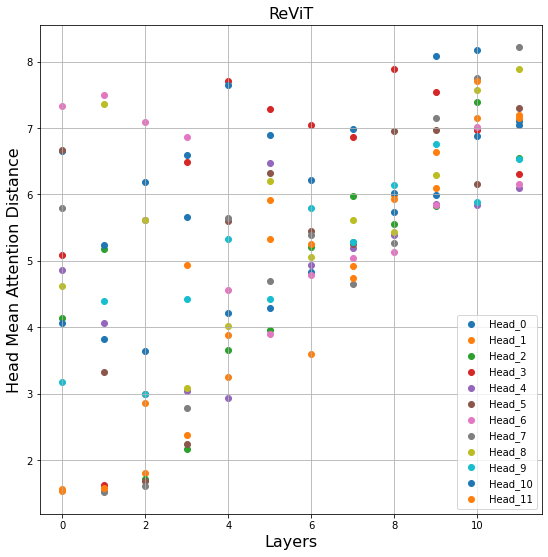

In [10]:
num_heads = 12
plt.figure(figsize=(9, 9))

# for idx in range(len(mean_distances)):
#     mean_distance = mean_distances[f"block_{idx}_distances"]
#     x = [idx] * num_heads
#     y = mean_distance[0]
#     plt.scatter(x=x, y=y, label=f"Layer_{idx}")
indices = np.asarray(torch.linspace(0, 11, 12))
for h in range(num_heads):
    head_attention = []
    for idx in range(len(mean_distances)):
        mean_distance = mean_distances[f"block_{idx}_distances"]
        head_attention.append(mean_distance[0, h])
    y = head_attention
    plt.scatter(x=indices, y=y, label=f"Head_{h}")

plt.legend(loc="lower right")
plt.xlabel("Layers", fontsize=16)
plt.ylabel("Head Mean Attention Distance", fontsize=16)
plt.title("ReViT", fontsize=16)
plt.grid()
plt.savefig("ReViT.pdf", dpi=300, format='pdf')
plt.show()

In [11]:
import transformers 
from transformers import ViTImageProcessor, ViTForImageClassification

model_ = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", output_attentions=True)
with torch.no_grad():
    outputs = model_(input_)

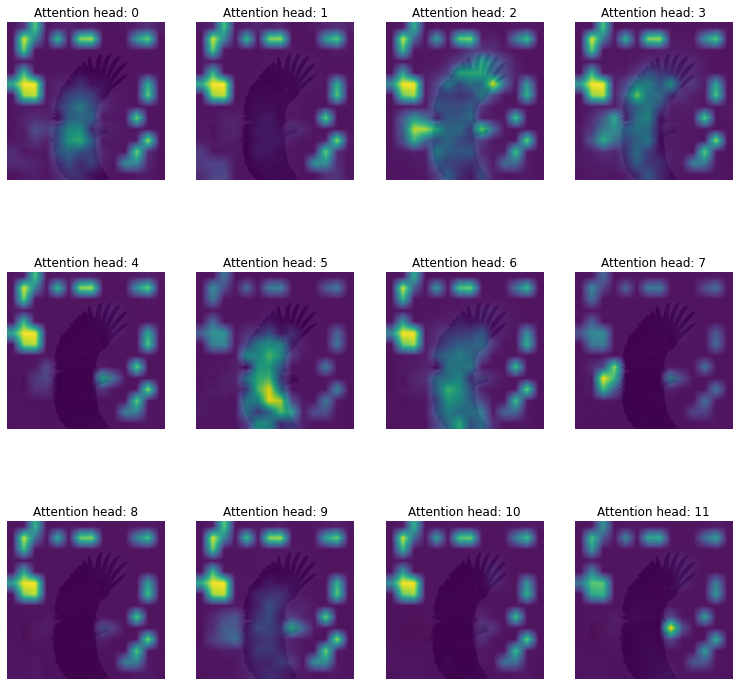

In [12]:
attn_maps = outputs['attentions']
maps = attention_heatmaps(attn_maps, input_, 9, True)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0
for i in range(3):
    for j in range(4):
        if img_count < 12:
            axes[i, j].imshow(img)
            axes[i, j].imshow(maps[img_count], cmap="viridis", alpha=0.9)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1
# fig.savefig("Original_ViT_attention_maps_bald_eagle_layer9.png")

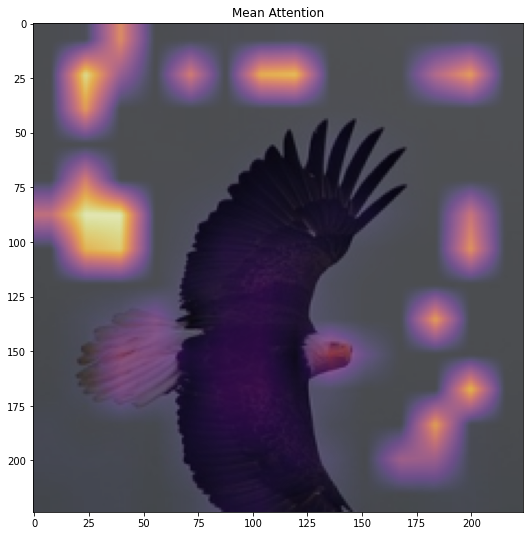

In [13]:
plt.figure(figsize=(9, 9))
mean_maps = maps.mean(dim=0)
img_count = 0
plt.imshow(img)
plt.imshow(mean_maps, cmap="inferno", alpha=0.6)
plt.title(f"Mean Attention")
plt.savefig("ViT_original_attention_maps_eagle.png")
        

In [14]:
attention_maps_vit = outputs['attentions']
mean_distances_vit = {}
for i in range(len(attention_maps_vit)):
    attention_map_vit = attention_maps_vit[i][:,:, 1:, 1:].squeeze()
    mean_distances_vit[f"block_{i}_distances"] = compute_mean_attention_dist(patch_size=16, attention_weights=attention_map_vit, module=False)

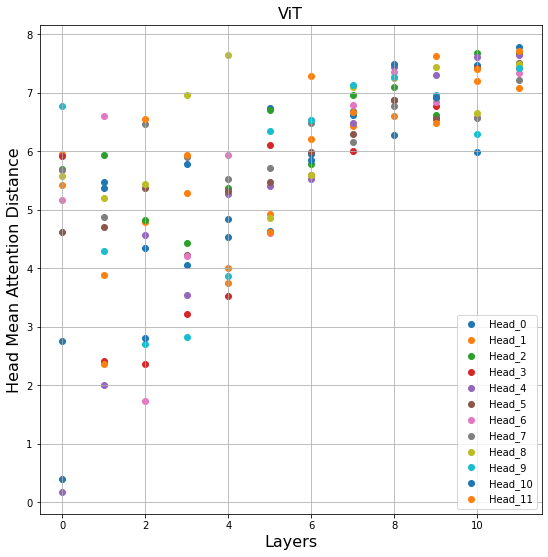

In [15]:
num_heads = 12
plt.figure(figsize=(9, 9))

# for idx in range(len(mean_distances_vit)):
#     mean_distance = mean_distances_vit[f"block_{idx}_distances"]
#     x = [idx] * num_heads
#     y = mean_distance[0]
#     plt.scatter(x=x, y=y, label=f"Layer_{idx}")

indices = np.asarray(torch.linspace(0, 11, 12))
for h in range(num_heads):
    head_attention = []
    for idx in range(len(mean_distances_vit)):
        mean_distance = mean_distances_vit[f"block_{idx}_distances"]
        head_attention.append(mean_distance[0, h])
    y = head_attention
    plt.scatter(x=indices, y=y, label=f"Head_{h}")

plt.legend(loc="lower right")
plt.xlabel("Layers", fontsize=16)
plt.ylabel("Head Mean Attention Distance", fontsize=16)
plt.title("ViT", fontsize=16)
plt.grid()
plt.savefig("ViT.pdf", dpi=300, format='pdf')
plt.show()